<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of single-cell RNA-seq data: building and annotating an atlas
This Python notebook pre-processes the [pbmc_1k v3 dataset](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v3) from 10X Genomics with kallisto and bustools using `kb`, and then performs an analysis of the cell types and their marker genes.

The notebook was written by A. Sina Booeshaghi and Lior Pachter and is based on three noteboks:
- The kallisto | bustools [Introduction to single-cell RNA-seq I](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_1_minute_intro.ipynb#scrollTo=wtwMjIjjCMcD) notebook.
- The kallisto | bustools [Introduction to single-cell RNA-seq II](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_standard.ipynb#scrollTo=ijU_u6uj3Sio) notebook.
- The Scanpy [Preprocessing and clustering 3k PBMCs" notebook](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Wolf, F. A., Angere, P. and Theis, F.J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biology (2018). doi:10.1186/s13059-017-1382-0

An R notebook implementing the same analysis is available [here](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_R.ipynb). See the [kallistobus.tools tutorials](https://www.kallistobus.tools/tutorials) site for additional notebooks demonstrating other analyses.

## Setup

In [0]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [0]:
%%time
# These packages are pre-installed on Google Colab, but are included here to simplify running this notebook locally
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
!pip3 install leidenalg
!pip install louvain
!pip install scanpy

     |████████████████████████████████| 92kB 2.2MB/s 
  Created wheel for louvain: filename=louvain-0.6.1-cp36-cp36m-linux_x86_64.whl size=1024949 sha256=5addbeb98a4424a3c915fc3e5416a15a41c5b707cefa2f082ccd62d36655d17a
  Stored in directory: /root/.cache/pip/wheels/f2/c3/d4/f7abaf064186d6214ef952bbb72fd6c5136d4b17dbeaeff481
Successfully built louvain
CPU times: user 1.38 s, sys: 319 ms, total: 1.7 s
Wall time: 3min 44s


### Install kb-python

In [0]:
%%time
# install kb
!pip install kb-python 

     |████████████████████████████████| 35.4MB 109kB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=e61df8a6213b5a000a43369313f030375510d6bad2a151051fd24aa4543cf7d1
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28042 sha256=08f9947469d78f8300adb39bbd625fcc5aff68f4b9950ef9f24254d431cbaddb
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built loompy numpy-groupies
CPU times: user 353 ms, sys: 89.7 ms, total: 443 ms
Wall time: 11.7 s


### Download the data

In [0]:
%%time
# Download the data from the 10x website
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar

# unpack the downloaded files
!tar -xvf pbmc_1k_v3_fastqs.tar

--2020-02-07 22:13:57--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.226.113.21, 13.226.113.37, 13.226.113.61, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.226.113.21|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5549312000 (5.2G) [application/x-tar]
Saving to: ‘pbmc_1k_v3_fastqs.tar’

pbmc_1k_v3_fastqs.t 100%[===================>]   5.17G  33.8MB/s    in 2m 40s  

2020-02-07 22:16:38 (33.1 MB/s) - ‘pbmc_1k_v3_fastqs.tar’ saved [5549312000/5549312000]

pbmc_1k_v3_fastqs/
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz
CPU times: user 1.87 s, sys: 393 ms, total: 2.26 s
Wall time: 4min 17

### Download an index

This data consists of peripheral blood mononuclear cells from a human, so we download the human index.

In [0]:
!kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2020-02-07 22:18:20,494]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
[2020-02-07 22:20:56,952]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


## Pseudoalignment and counting

### Run kallisto and bustools

In [0]:
%%time
!kb count --h5ad -i index.idx -g t2g.txt -x 10xv3 -o output --filter bustools -t 2 \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz

[2020-02-07 22:21:43,406]    INFO Generating BUS file from
[2020-02-07 22:21:43,407]    INFO         pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz
[2020-02-07 22:21:43,407]    INFO         pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz
[2020-02-07 22:21:43,407]    INFO         pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz
[2020-02-07 22:21:43,407]    INFO         pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz
[2020-02-07 22:35:44,867]    INFO Sorting BUS file output/output.bus to tmp/output.s.bus
[2020-02-07 22:36:18,698]    INFO Whitelist not provided
[2020-02-07 22:36:18,698]    INFO Copying pre-packaged 10XV3 whitelist to output
[2020-02-07 22:36:19,918]    INFO Inspecting BUS file tmp/output.s.bus
[2020-02-07 22:36:37,665]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist output/10xv3_whitelist.txt
[2020-02-07 22:40:43,336]    INFO Sorting BUS file tmp/output.s.c.bus to output/output.unfiltered.bus
[2020-02-07 22:40:55

## Basic QC

In [0]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt


In [0]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.5 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2 python-igraph==0.7.1


In [0]:
# load the unfiltered matrix
results_file = 'pbmc1k.h5ad'  # the file that will store the analysis results
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [0]:
adata

AnnData object with n_obs × n_vars = 259615 × 60623 
    var: 'gene_id', 'gene_name'

### Test for library saturation

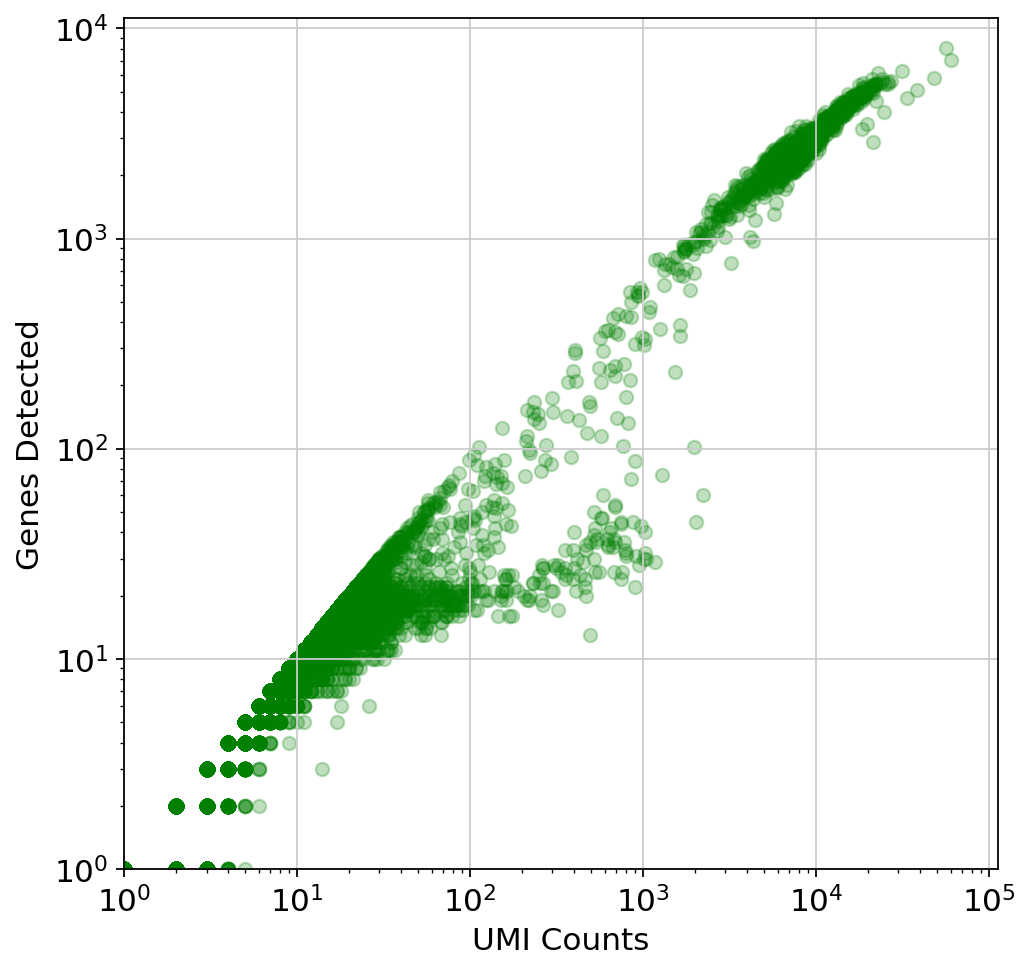

In [0]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(7, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)


plt.show()

This plot is very misleading, as even the small alpha can't accurately show how many points are stacked at one location (This takes about a minute to run since there are a lot of points)

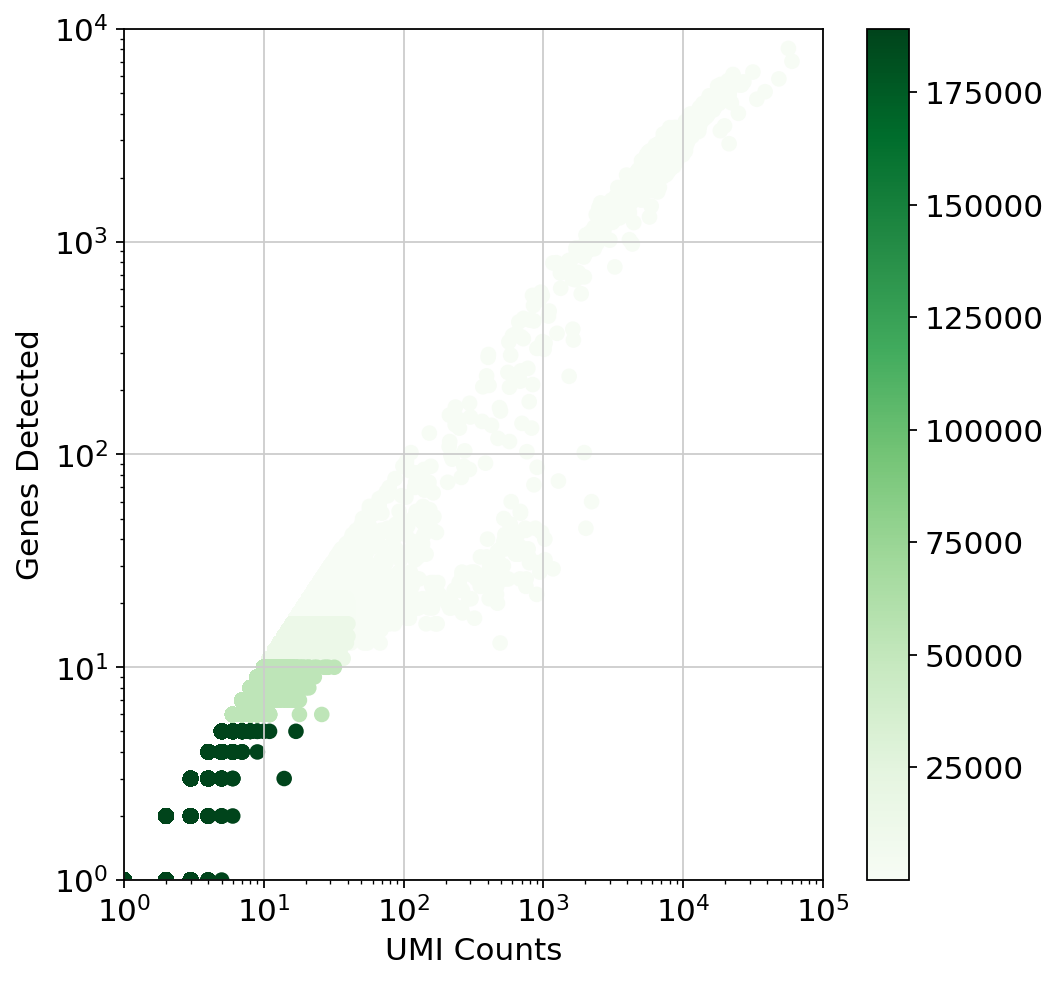

In [0]:
fig, ax = plt.subplots(figsize=(7,7))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]


s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

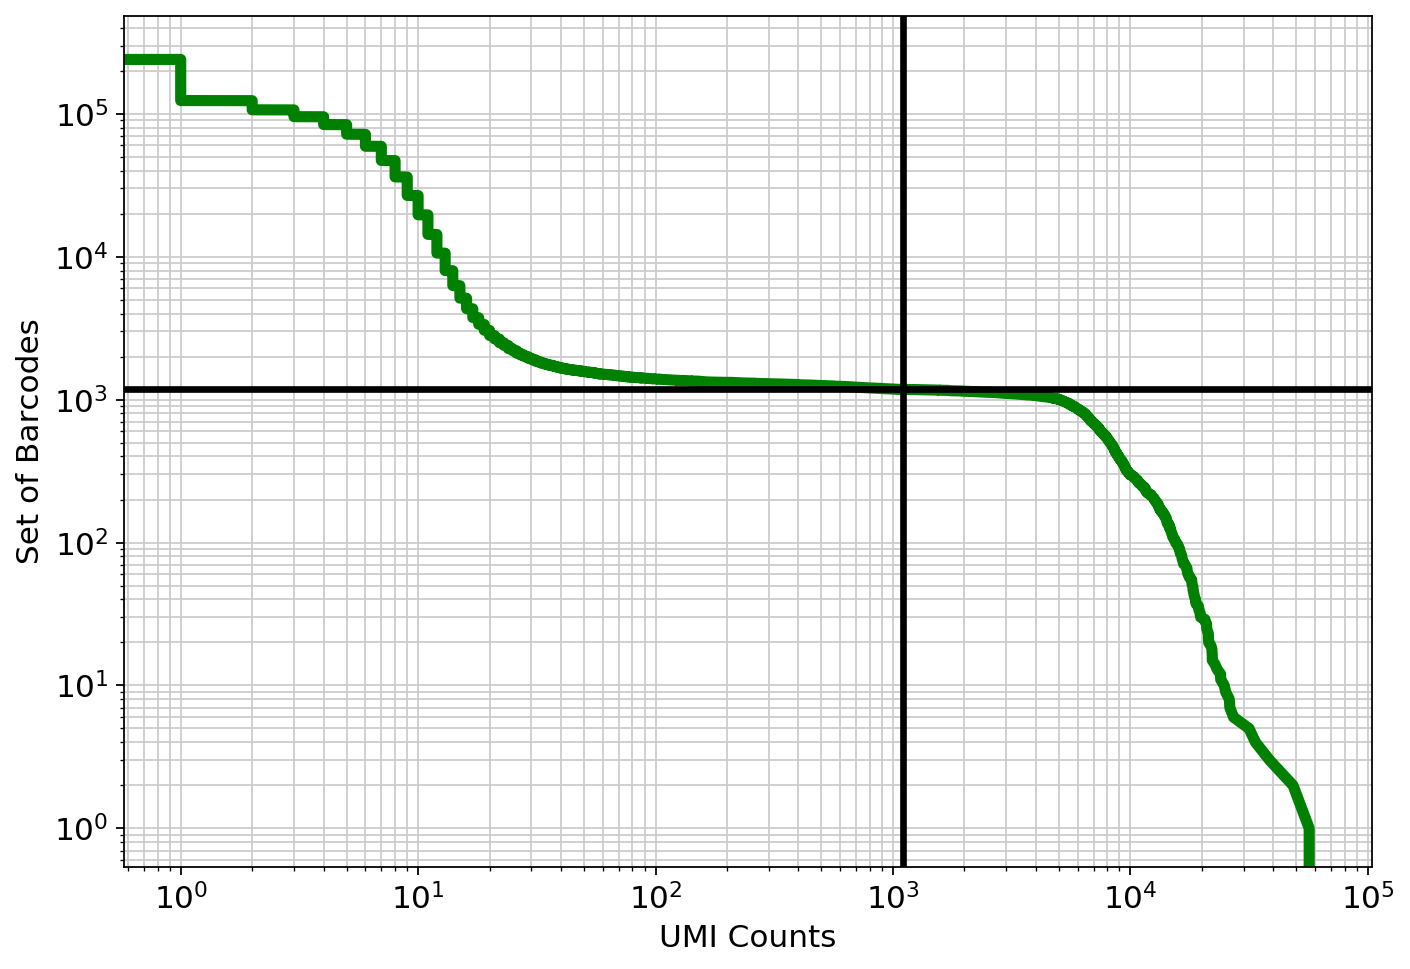

In [0]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells =  1178#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

## Analysis

It is useful to examine mitochondrial genes, which are important for quality control. [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics) write that

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


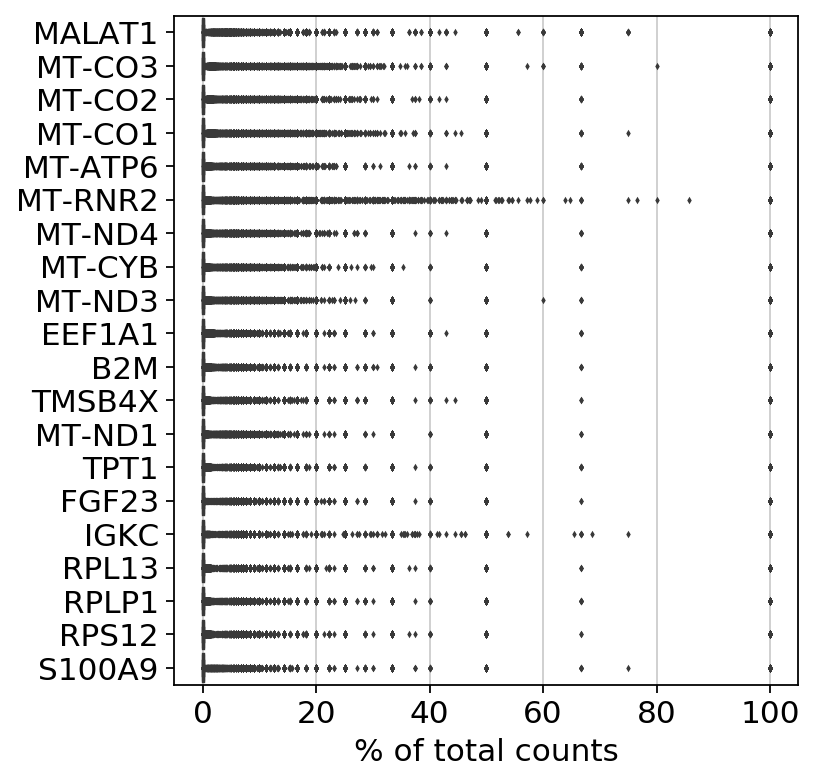

In [0]:
sc.pl.highest_expr_genes(adata, n_top=20)

### Filter

Begin by filtering cells according to various criteria. First, a filter for genes and cells based on minimum thresholds:

In [0]:
# Removes cells with less than 1070 umi counts
adata = adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > 1070]

# Removes genes with 0 umi counts
adata = adata[:, np.asarray(adata.X.sum(axis=0)).reshape(-1) > 0]

In [0]:
adata

View of AnnData object with n_obs × n_vars = 1180 × 31837 
    var: 'gene_id', 'gene_name'

In [0]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 5 cells that have less than 200 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 5884 genes that are detected in less than 3 cells


In [0]:
adata

AnnData object with n_obs × n_vars = 1175 × 25953 
    obs: 'n_genes'
    var: 'gene_id', 'gene_name', 'n_cells'

Next, filter by mitochondrial gene content

In [0]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Perform a QC check of the counts post-filtering

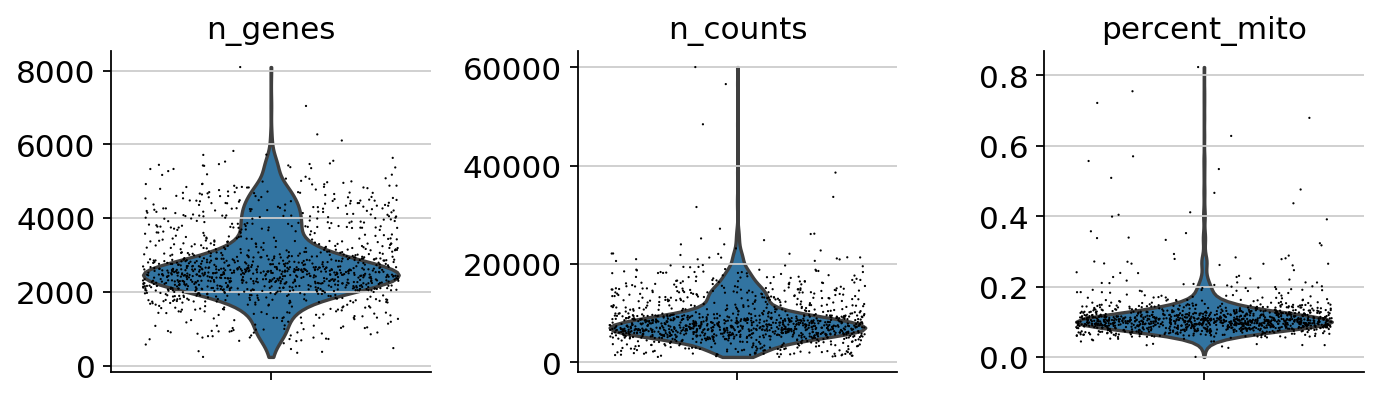

In [0]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

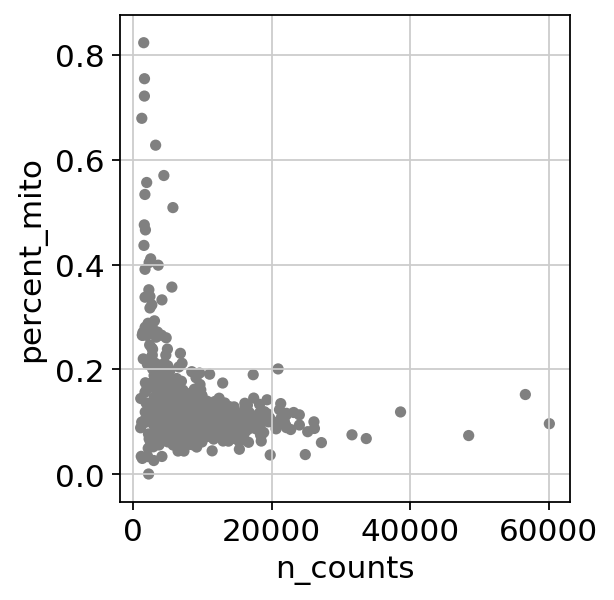

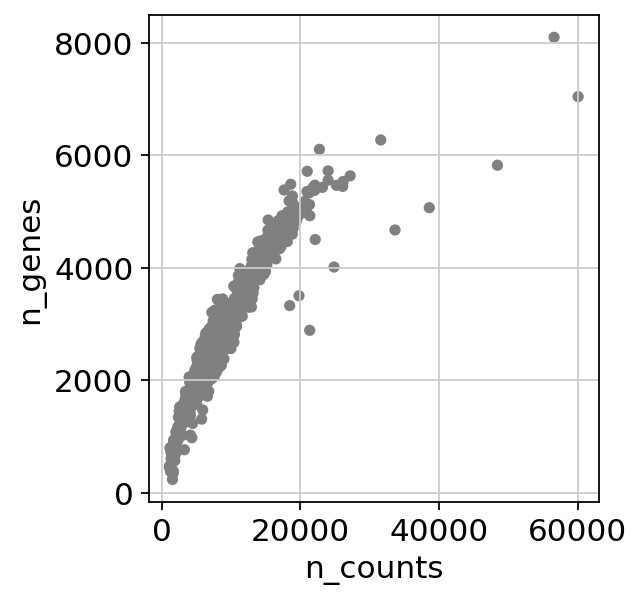

In [0]:
#examine mitochondrial content 
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [0]:
# Create a mask to filter out cells with more than 6500 genes, less than 200 genes or less than 0.2 mitochondrial umi counts
mask = np.logical_or((adata.obs.n_genes < 6500).values, (adata.obs.n_genes > 200).values, (adata.obs.percent_mito < 0.2).values)

In [0]:
#filter
adata = adata[mask, :]

In [0]:
adata

View of AnnData object with n_obs × n_vars = 1175 × 25953 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_id', 'gene_name', 'n_cells'

### Normalize counts

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [0]:
# normalize counts in each cell to be equal
sc.pp.normalize_total(adata, target_sum=10**4)

normalizing counts per cell
    finished (0:00:02)


Log the counts

In [0]:
# Replace raw counts with their logarithm
sc.pp.log1p(adata)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


Lets now look at the highest expressed genes after filtering, normalization, and log

normalizing counts per cell
    finished (0:00:00)


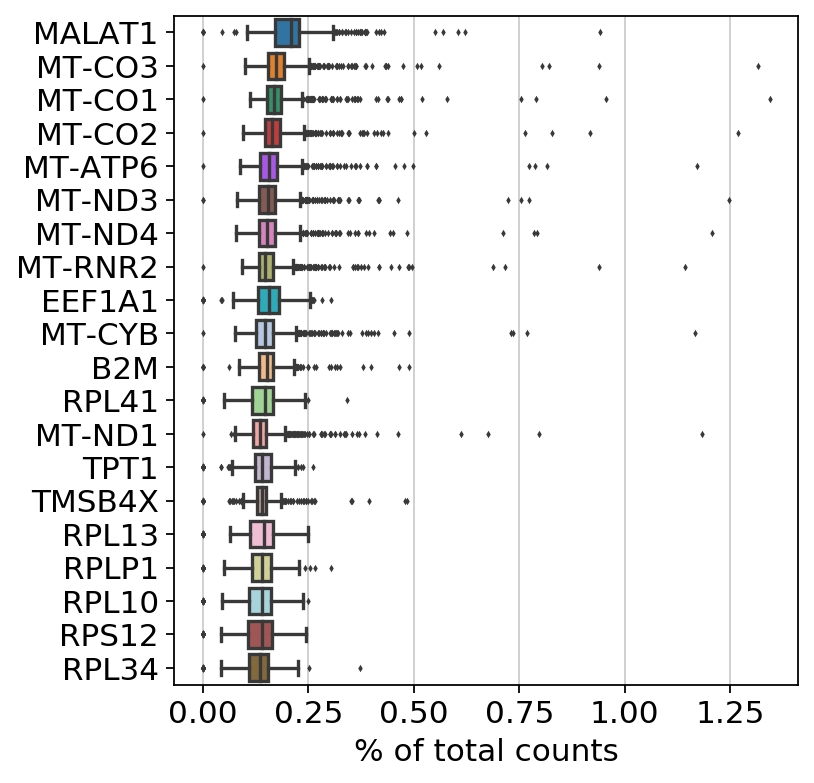

In [0]:
sc.pl.highest_expr_genes(adata, n_top=20)

Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

The unnormalized data is stored in `.raw`.

In [0]:
adata.raw = adata

<div class="alert alert-info">

**Note**
The result of the following highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools.

</div>

### Identify highly-variable genes.

In [0]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=2000, flavor="cell_ranger", n_bins=20)

extracting highly variable genes
If you pass `n_top_genes`, all cutoffs are ignored.
    finished (0:00:01)


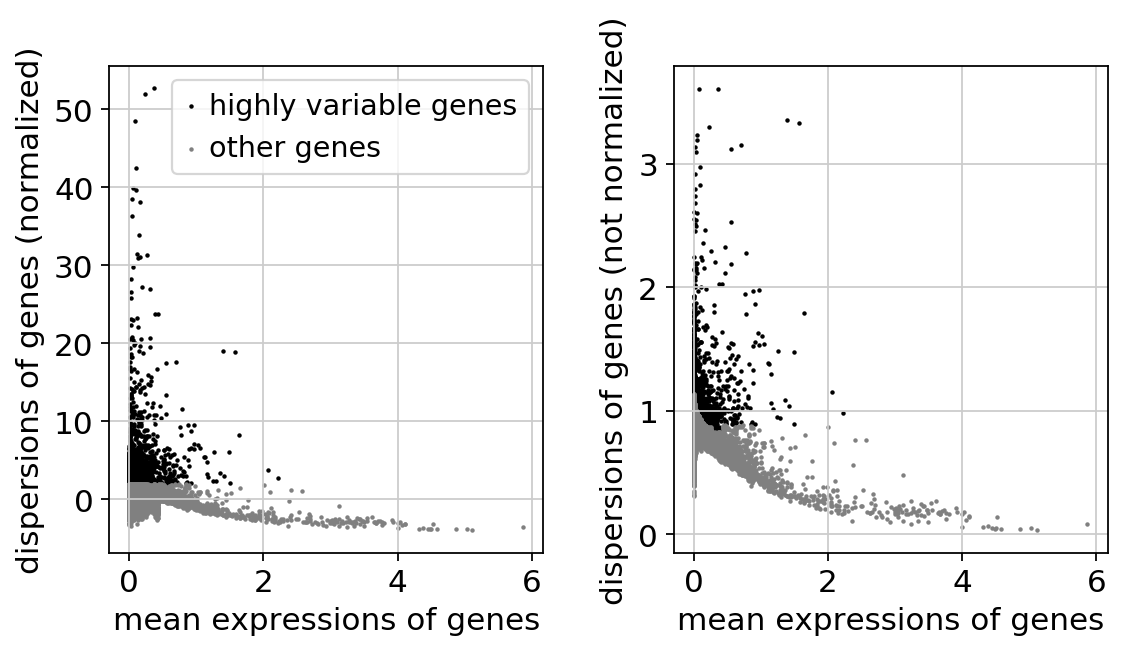

In [0]:
sc.pl.highly_variable_genes(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

We do not regress out as per https://github.com/theislab/scanpy/issues/526

In [0]:
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

### Scaling the data
Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [0]:
sc.pp.scale(adata, max_value=10)

### Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [0]:
# We perform PCA on just the highly variable genes
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


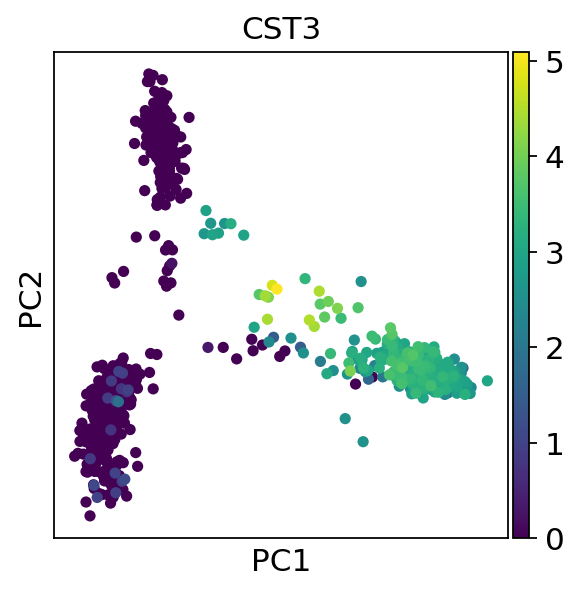

In [0]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.leiden()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

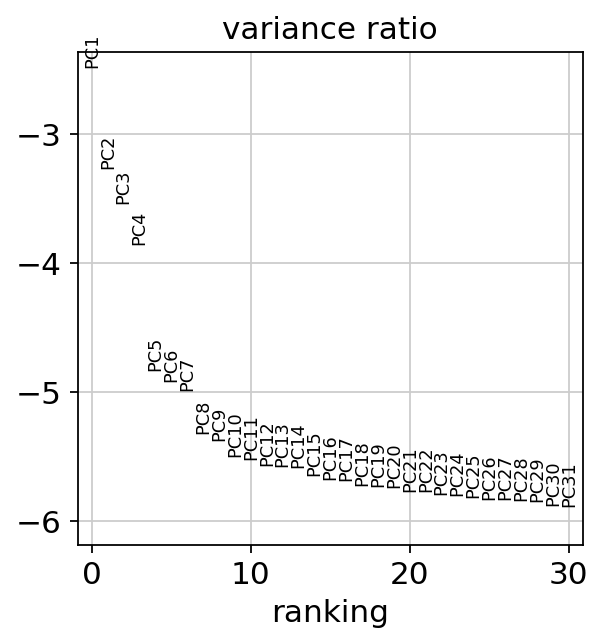

In [0]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result if you'd like.

In [0]:
!mkdir write

mkdir: cannot create directory ‘write’: File exists


In [0]:
adata.write(results_file)

In [0]:
adata

AnnData object with n_obs × n_vars = 1175 × 25953 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Compute the neighborhood graph

Next we compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. In order to be consistent with Seurat's results, we use the following values.

In [0]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:00)


### Embed the neighborhood graph

### UMAP

UMAP (UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction) is a manifold learning technique that can also be used to visualize cells. It was published in:

- McInnes, Leland, John Healy, and James Melville. "Umap: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).

We run that to visualize the results:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [0]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:03)


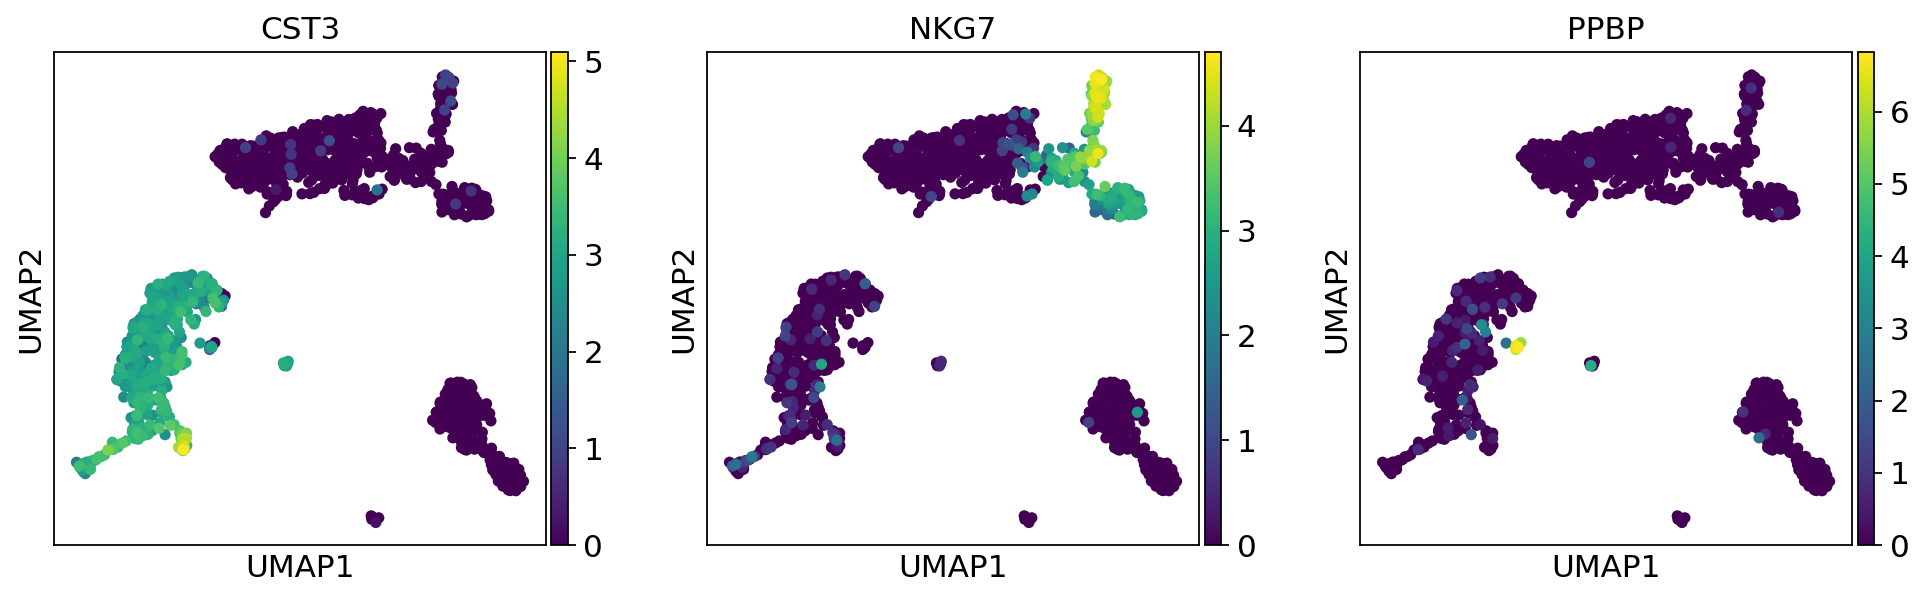

In [0]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

### Cluster the neighborhood graph

### Clustering

There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., [Duo et al. 2018](https://f1000research.com/articles/7-1141/v2)), there is no univerally agreed upon method. Here we demonstrate clustering using [Louvain clustering](https://en.wikipedia.org/wiki/Louvain_modularity), which is a popular method for clustering single-cell RNA-seq data. The method was published in 

- Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008.

Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [0]:
sc.tl.louvain(adata,resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


A plot of the clusters is shown below:

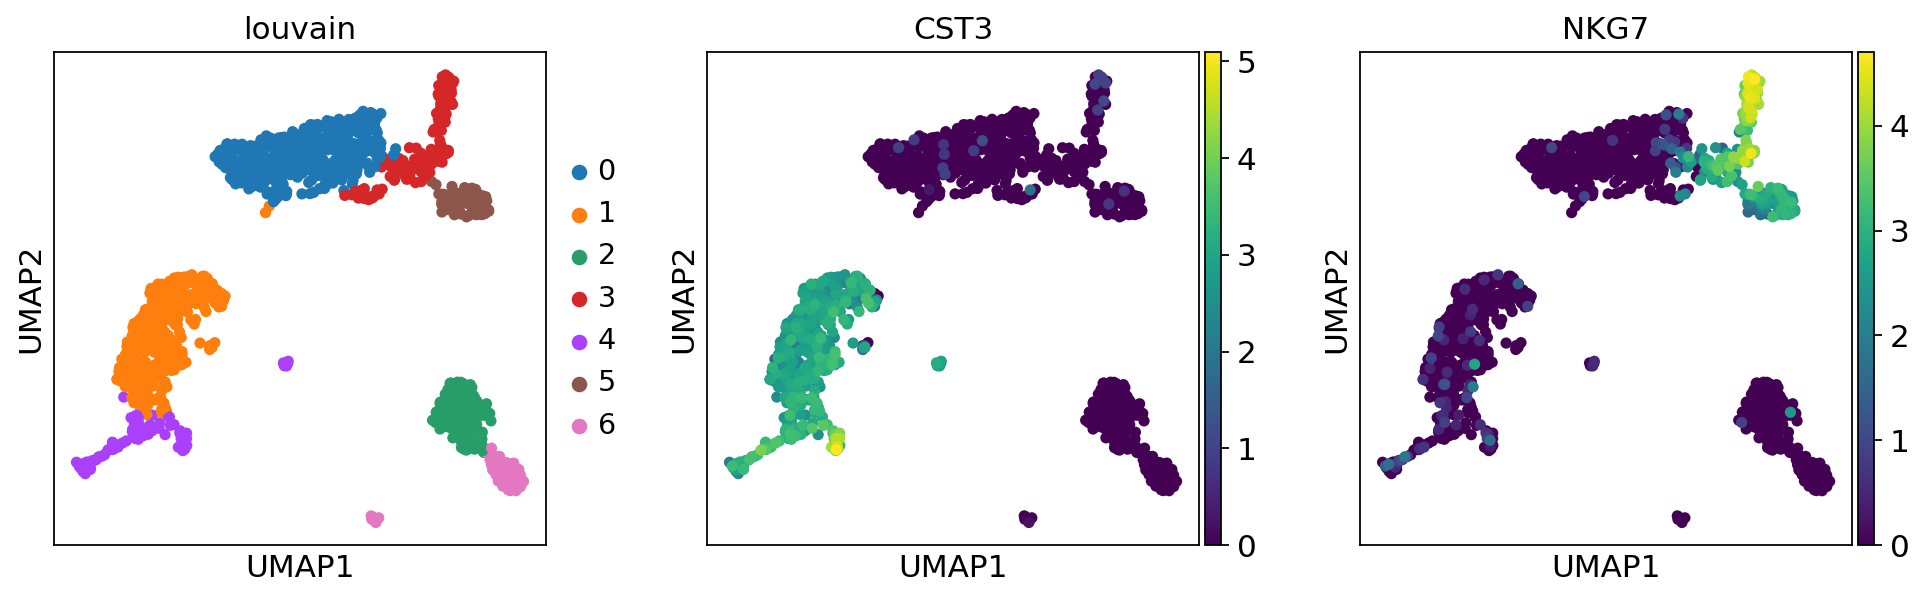

In [0]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

Save the result.

In [0]:
adata.write(results_file)

### Find marker genes

A key aspect of annotating a cell atlas is identifying "marker genes". These are genes specific to individual clusters that "mark" them, and are important both for assigning functions to cell clusters, and for designing downstream experiments to probe activity of clusters. 

A gene marker analysis begins with ranking genes in each cluster according to how different they are relative to other clusters. Typically the t-test is used for this purpose.

ranking genes
    finished (0:00:00)


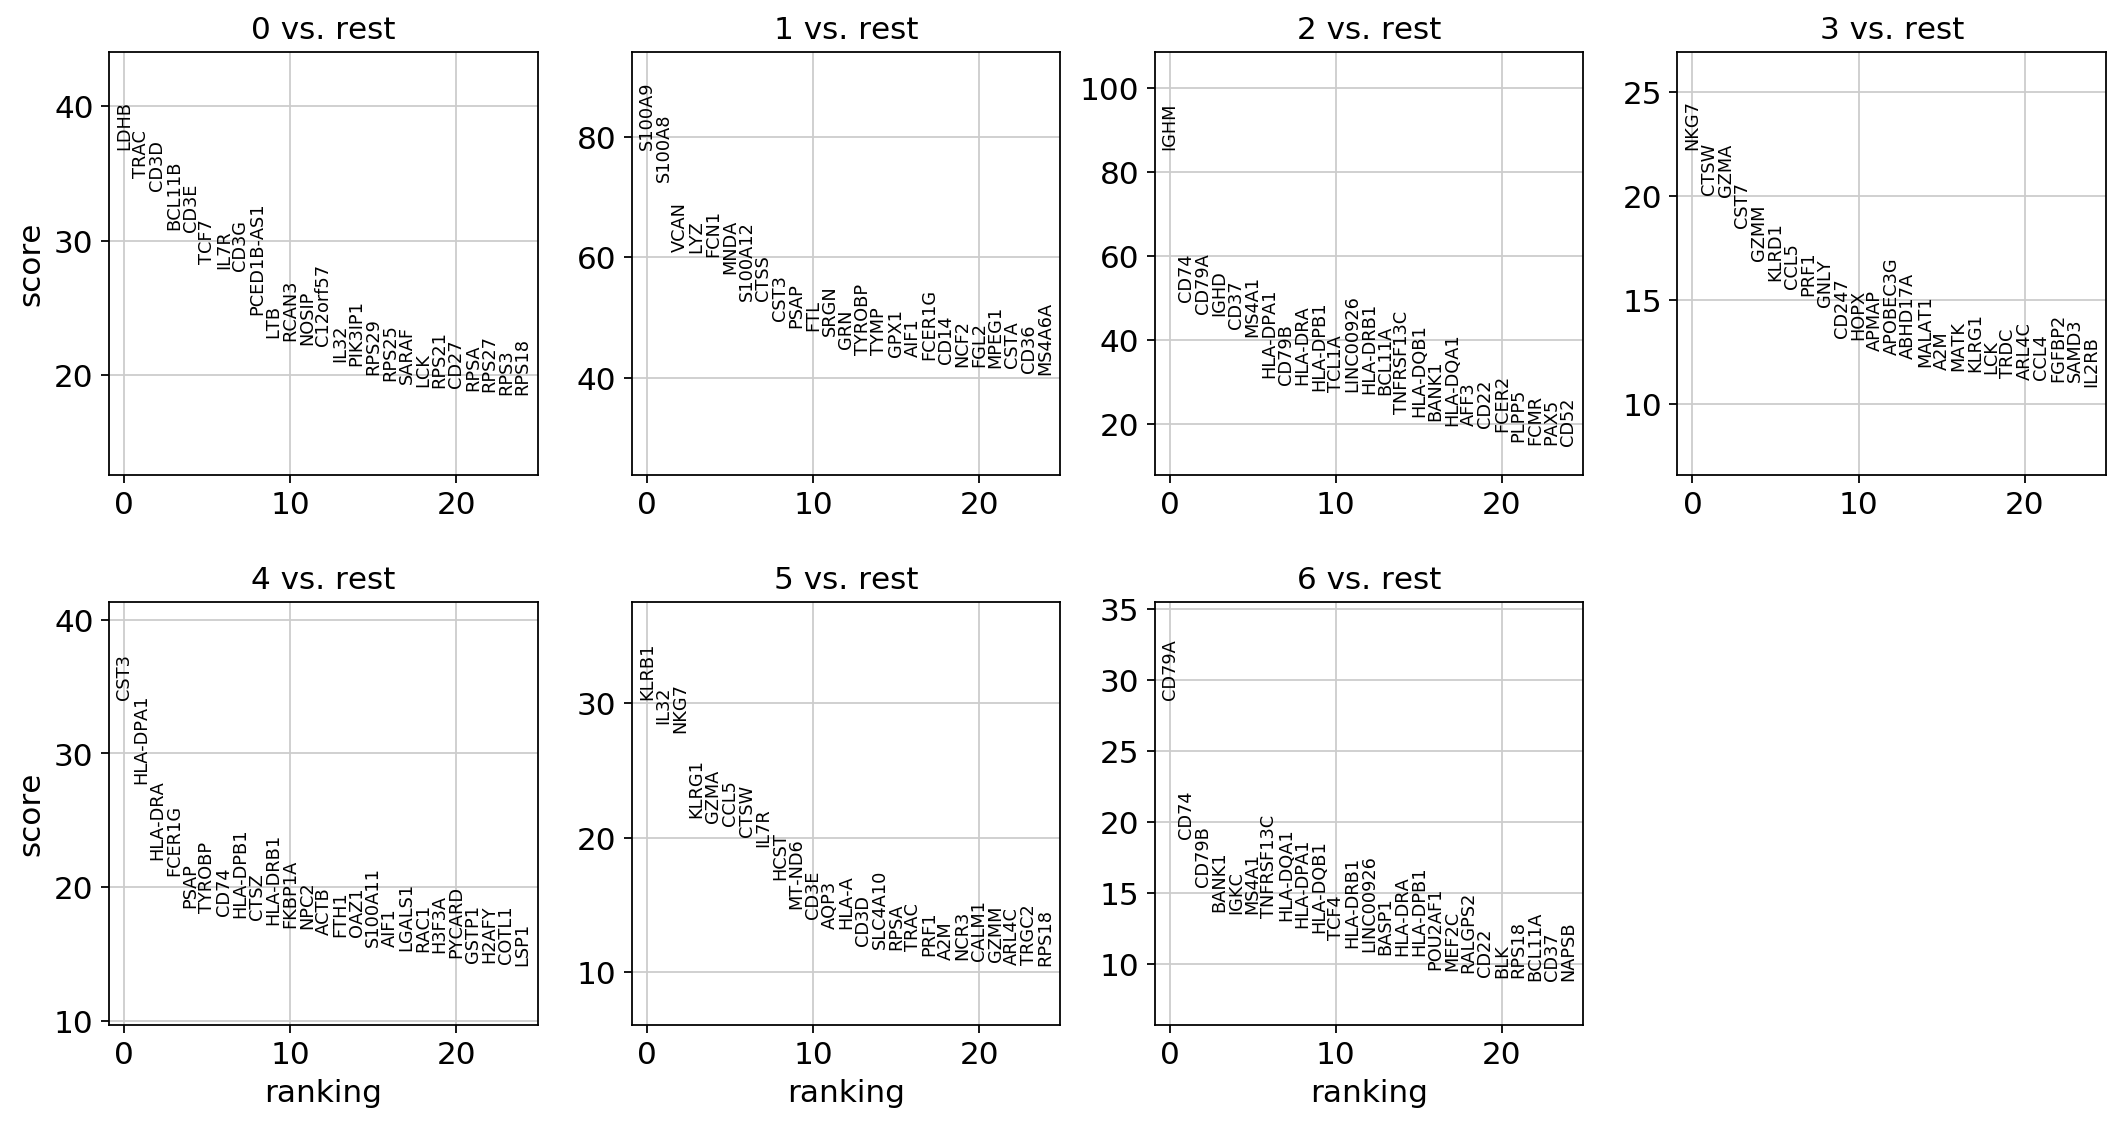

In [0]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [0]:
sc.settings.verbosity = 2  # reduce the verbosity

An alternative to the parametric t-test is the non-parametric [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test.

ranking genes
    finished (0:00:02)


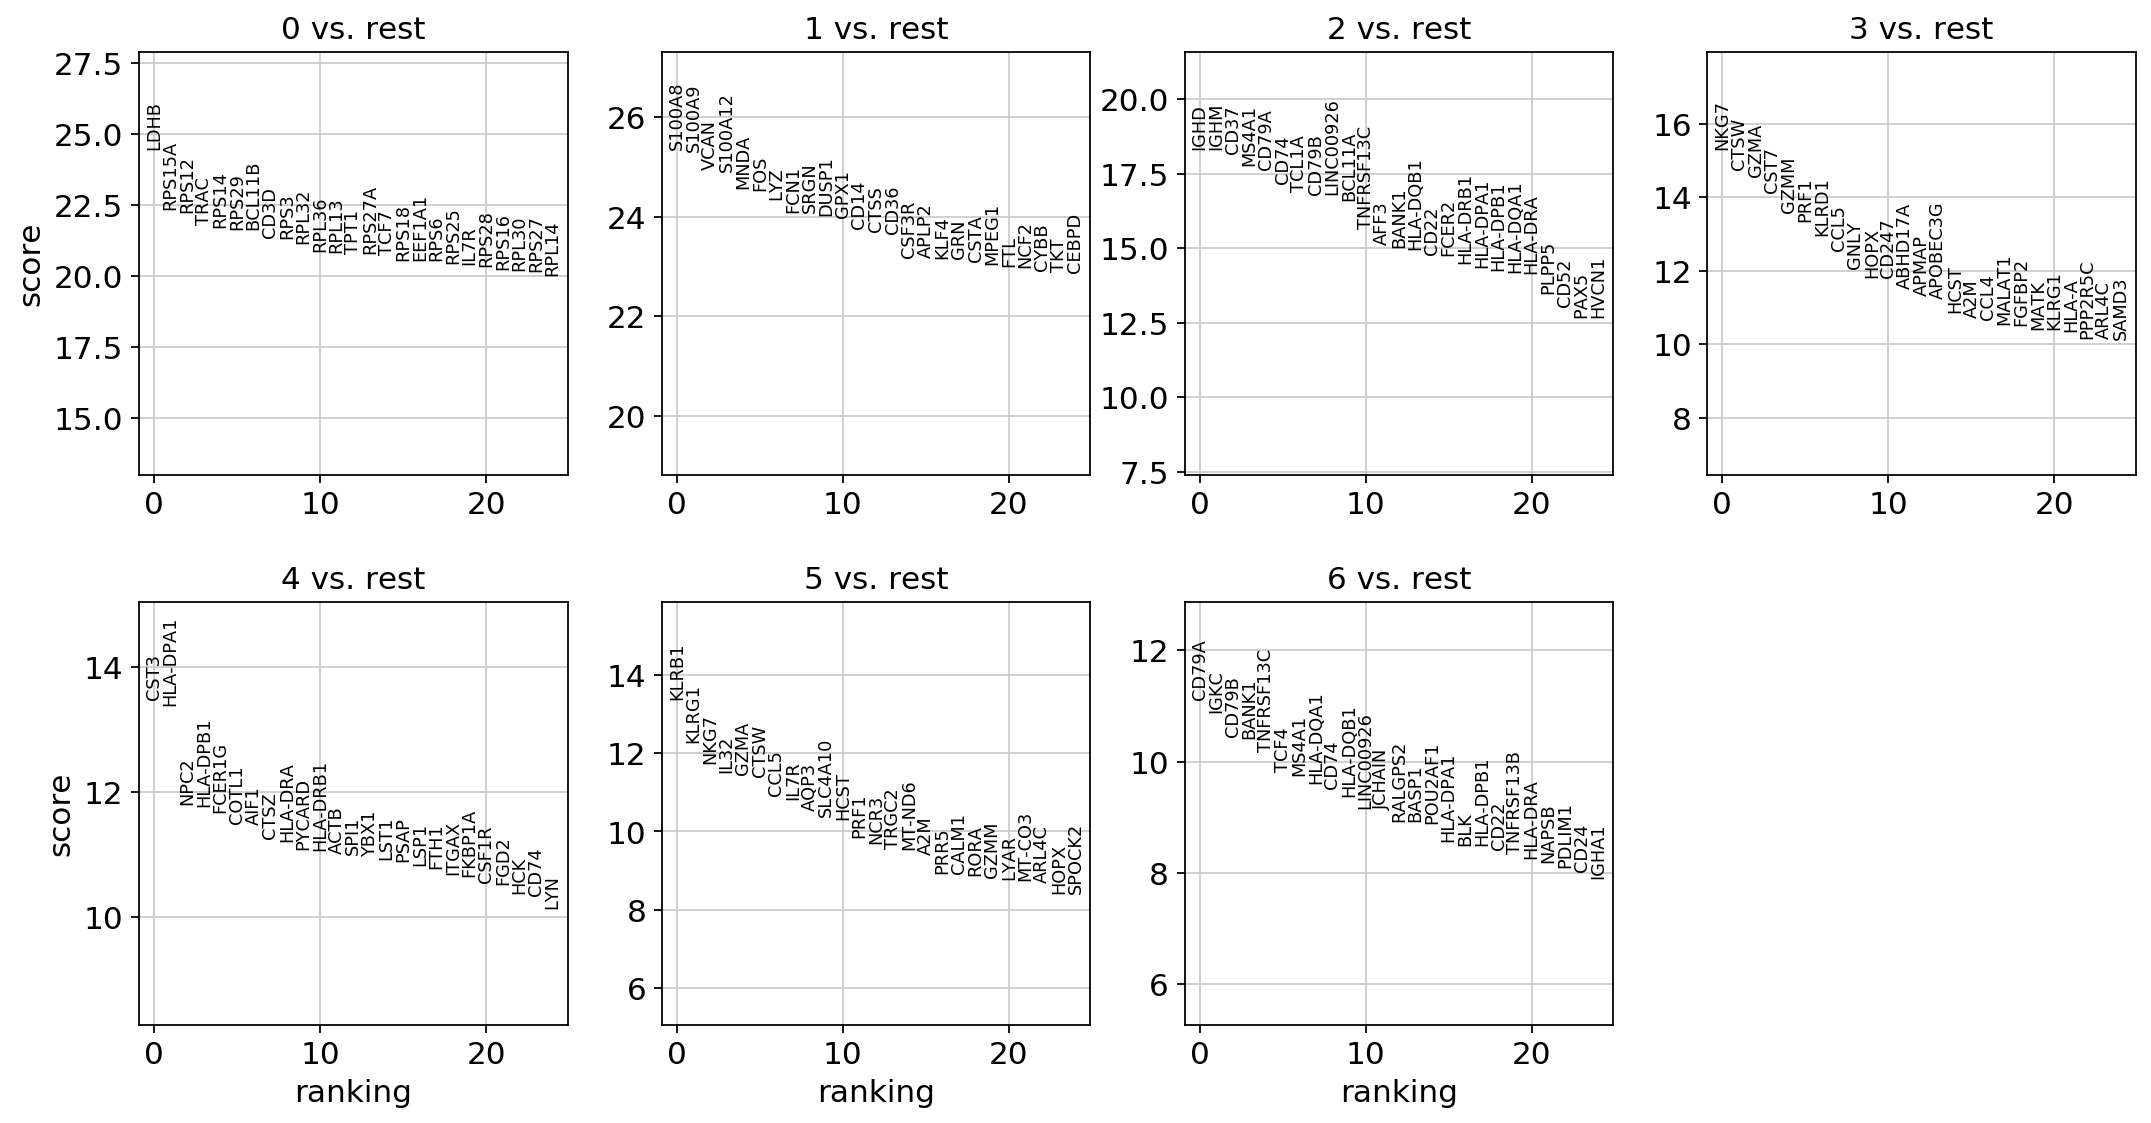

In [0]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [0]:
adata.write(results_file)

As an alternative, genes can be ranked using logistic regression (see [Natranos et al. (2018)](https://doi.org/10.1101/258566)).

ranking genes
    finished (0:00:15)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


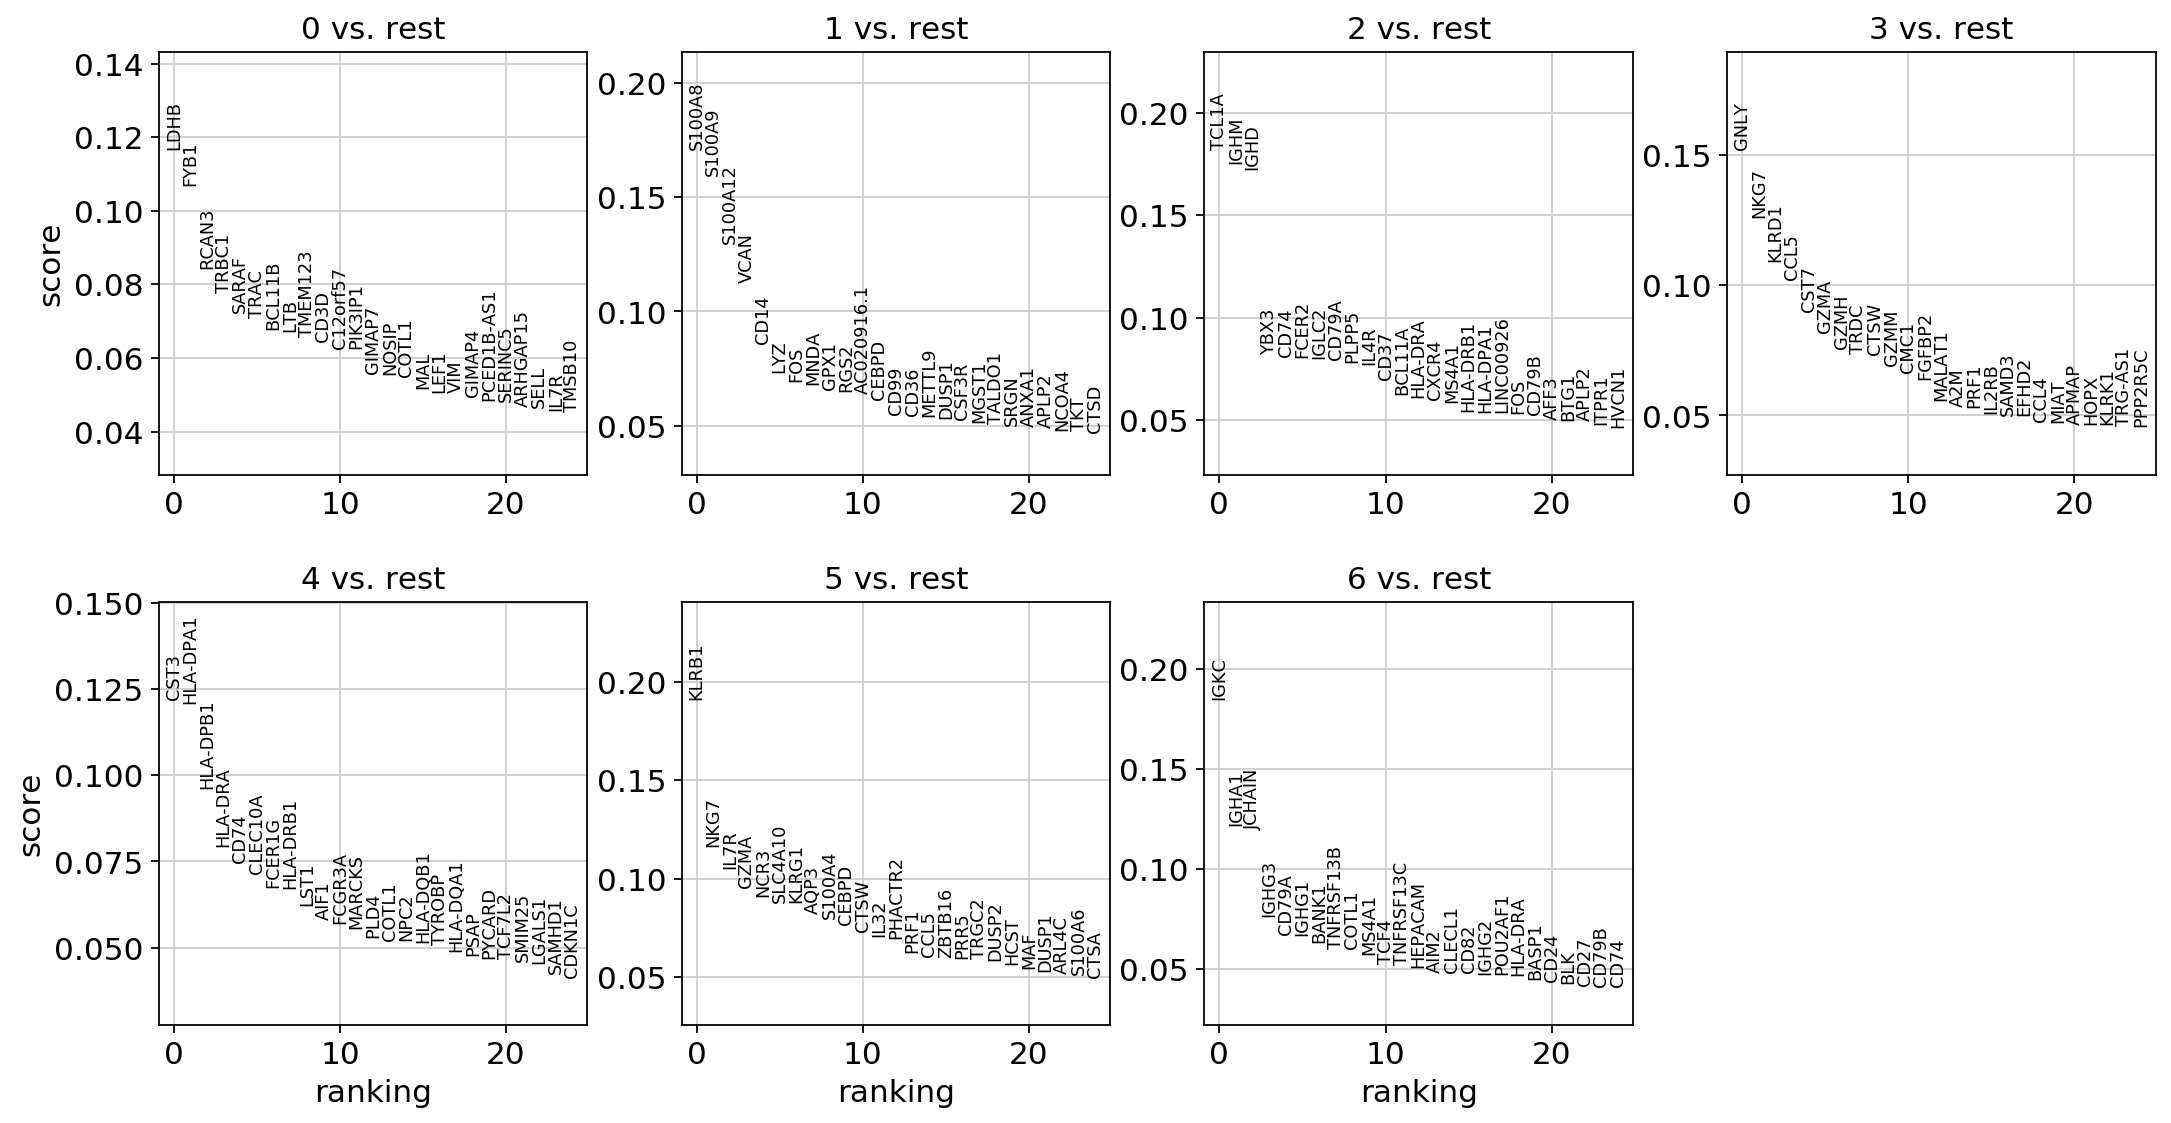

In [0]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | GNLY, NKG7 | 	NK cells
4 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
5 | CD8A |	CD8 T cells
6 | MS4A1 |	B cells

Let us also define a list of marker genes for later reference.

In [0]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [0]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [0]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6
0,LDHB,S100A8,IGHD,NKG7,CST3,KLRB1,CD79A
1,RPS15A,S100A9,IGHM,CTSW,HLA-DPA1,KLRG1,IGKC
2,RPS12,VCAN,CD37,GZMA,NPC2,NKG7,CD79B
3,TRAC,S100A12,MS4A1,CST7,HLA-DPB1,IL32,BANK1
4,RPS14,MNDA,CD79A,GZMM,FCER1G,GZMA,TNFRSF13C


Get a table with the scores and groups.

In [0]:
result.keys()

dict_keys(['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'])

In [0]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p
0,LDHB,4.516461e-132,S100A8,7.505366e-142,IGHD,5.910498e-75,NKG7,7.071959e-53,CST3,2.017979e-41,KLRB1,8.274802e-41,CD79A,9.836008e-29
1,RPS15A,1.541380e-110,S100A9,2.081678e-141,IGHM,6.105155e-75,CTSW,2.574017e-49,HLA-DPA1,7.445143e-41,KLRG1,1.245774e-34,IGKC,1.367137e-27
2,RPS12,2.055162e-109,VCAN,2.450077e-137,CD37,8.870612e-74,GZMA,3.949175e-48,NPC2,3.832086e-32,NKG7,7.556990e-32,CD79B,1.478383e-25
3,TRAC,1.822762e-105,S100A12,4.398791e-137,MS4A1,1.132038e-70,CST7,2.486254e-45,HLA-DPB1,5.624248e-32,IL32,1.135243e-30,BANK1,2.175950e-25
4,RPS14,1.821569e-104,MNDA,2.535172e-133,CD79A,1.022589e-69,GZMM,5.408959e-42,FCER1G,1.910180e-31,GZMA,1.885113e-30,TNFRSF13C,2.332597e-24


Compare to a single cluster. 

ranking genes
    finished (0:00:01)


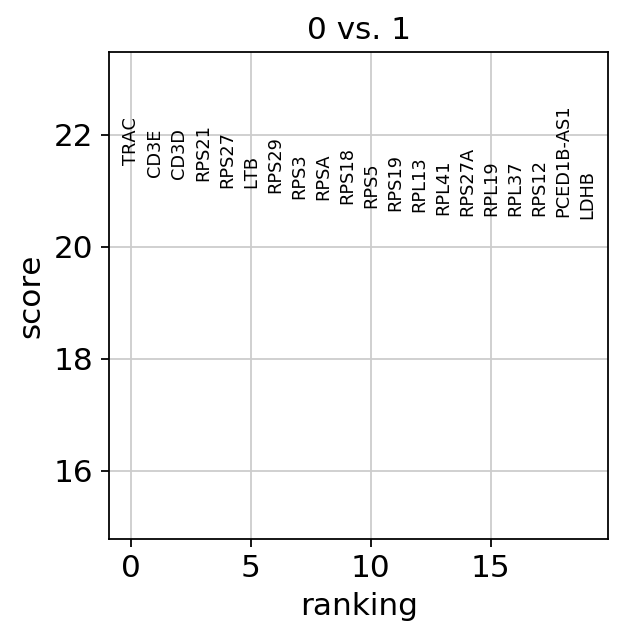

In [0]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

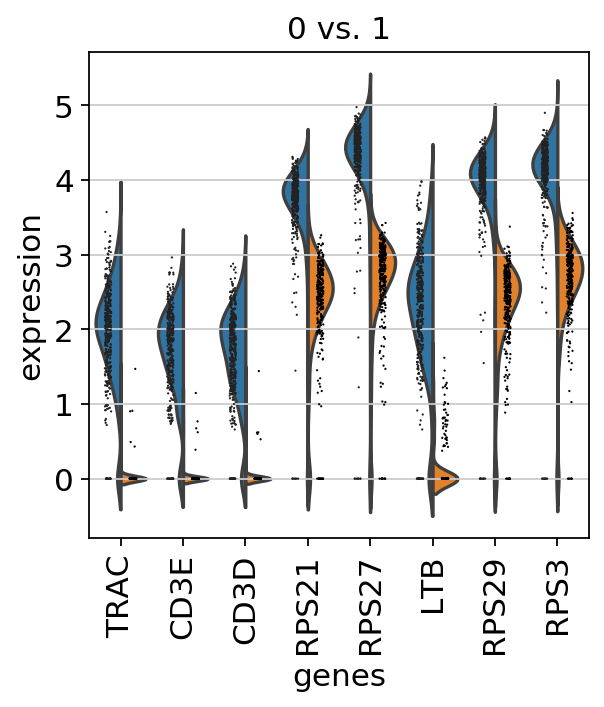

In [0]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [0]:
adata = sc.read(results_file)

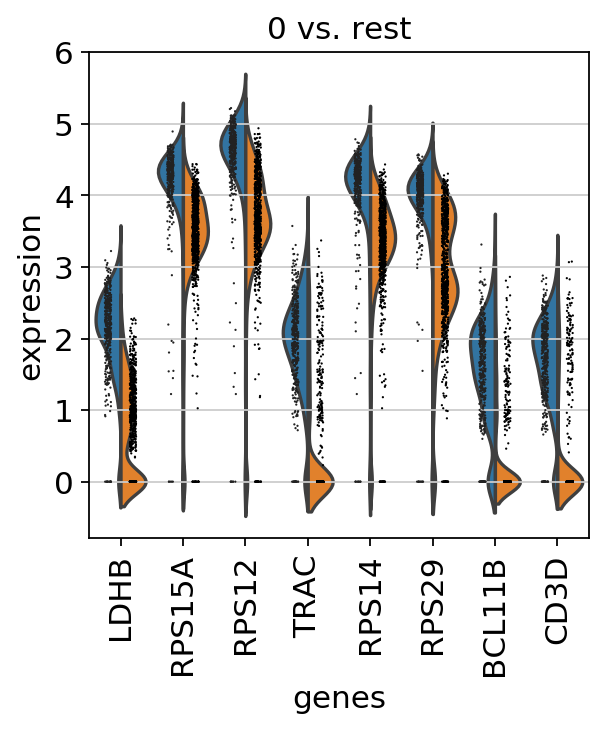

In [0]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

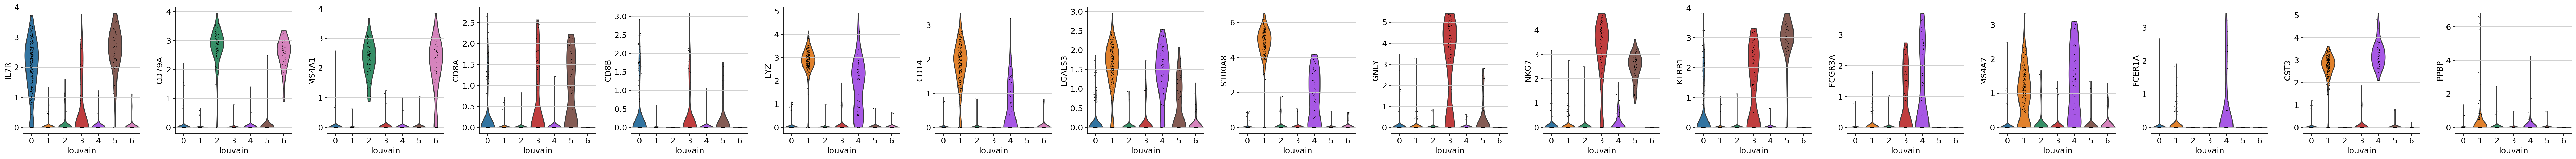

In [0]:
sc.pl.violin(adata, marker_genes, groupby='louvain')

Actually mark the cell types.

In [0]:
# Each cluster (index in the list) corresponds to a cell type
new_cluster_names = [
                     "CD4 T",
                     "CD14 Monocytes",
                     "B-1",
                     "NK",
                     "FCGR3A Monocytes",
                     "CD8 T",
                     "B-2"
]

In [0]:
 adata.rename_categories('louvain', new_cluster_names)

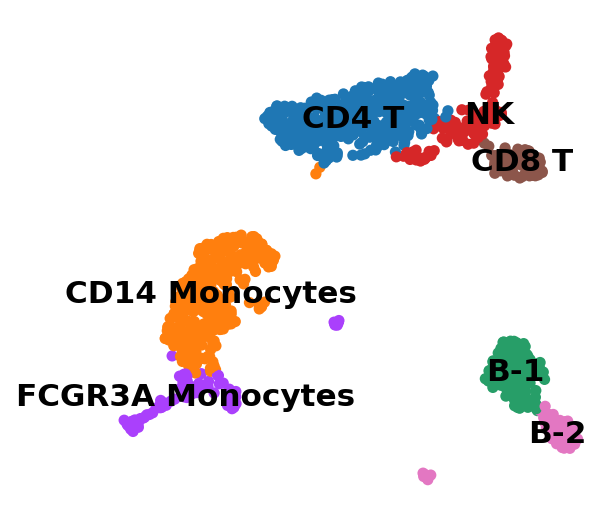

In [0]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False)

Now that we annotated the cell types, let us visualize the marker genes.

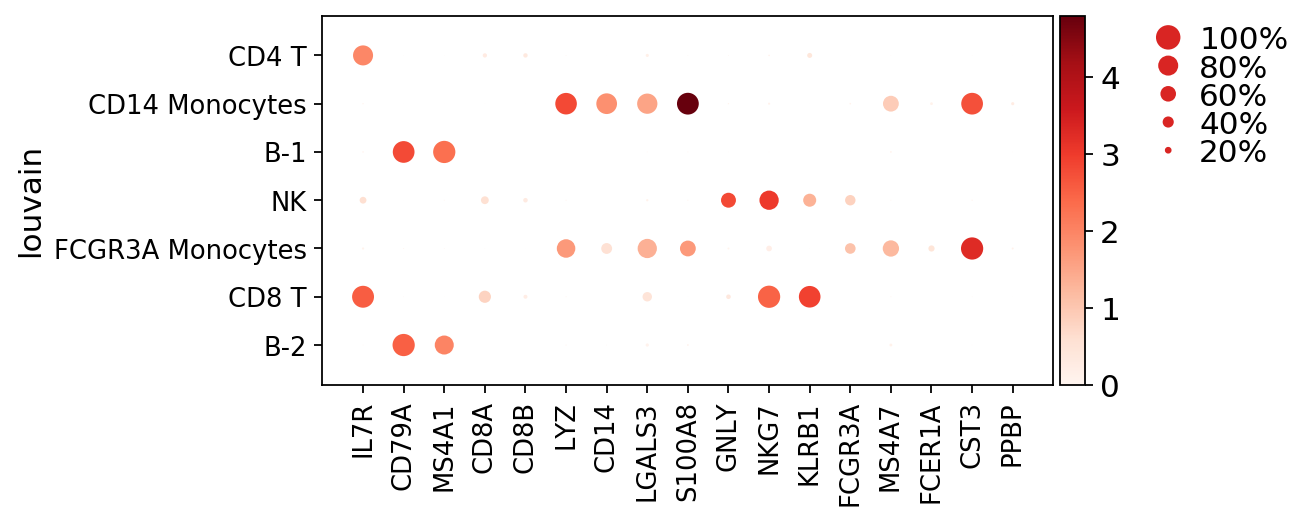

In [0]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

There is also a very compact violin plot.

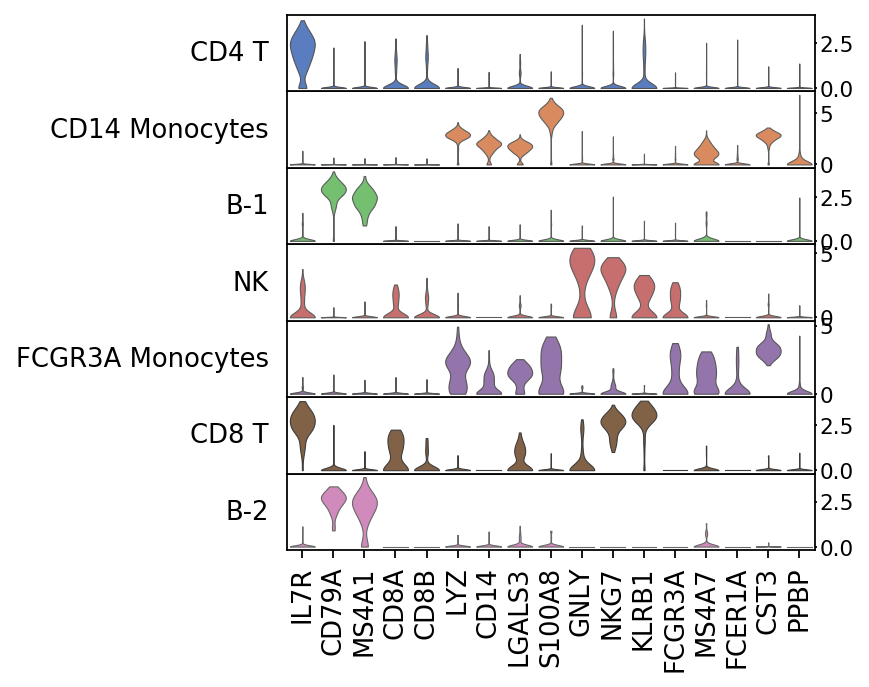

In [0]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

Note that as a result of the analysis the adata object has accumulated several annotations:

In [0]:
adata

AnnData object with n_obs × n_vars = 1175 × 25953 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [0]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to export to "csv", you have the following options:

In [0]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

In [0]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

32.21 minutes


**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_python.ipynb).